In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    'dataset/valid',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

classes = np.unique(train_generator.classes)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Found 490 images belonging to 4 classes.
Found 144 images belonging to 4 classes.
Found 630 images belonging to 4 classes.
Class Weights: {0: 0.6347150259067358, 1: 1.084070796460177, 2: 3.828125, 3: 0.805921052631579}


In [11]:
base_model1 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model2 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model1.trainable = True
for layer in base_model1.layers[:-30]:
    layer.trainable = False

base_model2.trainable = True
for layer in base_model2.layers[:-30]:
    layer.trainable = False

inputs = Input(shape=(224, 224, 3))
x1 = base_model1(inputs)
x1 = GlobalAveragePooling2D()(x1)
x2 = base_model2(inputs)
x2 = GlobalAveragePooling2D()(x2)
combined = Concatenate()([x1, x2])
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(combined)
x = Dropout(0.6)(x)
x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs, outputs)

In [12]:
lr_schedule = ExponentialDecay(initial_learning_rate=5e-5, decay_steps=5000, decay_rate=0.9)

model.compile(
    optimizer=AdamW(learning_rate=lr_schedule, weight_decay=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

In [13]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ModelCheckpoint('lung5.keras', monitor='val_accuracy', save_best_only=True, mode='max')
]

In [14]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

c:\Users\Md Ameen\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.2750 - loss: 8.2153 - recall: 0.1044 - val_accuracy: 0.2778 - val_loss: 7.8491 - val_recall: 0.0000e+00
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 748ms/step - accuracy: 0.3121 - loss: 7.8031 - recall: 0.1057 - val_accuracy: 0.3056 - val_loss: 7.6997 - val_recall: 0.0000e+00
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 23s 736ms/step - accuracy: 0.3218 - loss: 7.6628 - recall: 0.0764 - val_accuracy: 0.2917 - val_loss: 7.5953 - val_recall: 0.0139
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 766ms/step - accuracy: 0.3483 - loss: 7.5415 - recall: 0.0718 - val_accuracy: 0.2361 - val_loss: 7.4807 - val_recall: 0.0139
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 24s 760ms/step - accuracy: 0.3700 - loss: 7.4699 - recall: 0.0888 - val_accuracy: 0.2778 - val_loss: 7.3454 - val_recall: 0.0139
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 25s 793ms/step - accuracy: 0.3796 - loss: 7.3530 - recall: 0.1552 - val_accuracy: 0.3194 - val_loss: 7.2185 - val_re

In [15]:
from tensorflow.keras.models import load_model

loaded_model = load_model("lung5.keras")
print("Model loaded successfully!")

Model loaded successfully!


In [16]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
OUTPUT_SIZE = 4

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
The image belongs to class: adenocarcinoma


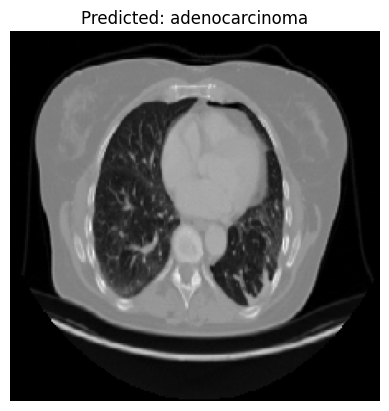

In [17]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  
    return img_array

img_path = 'content/a1.png'  
img = load_and_preprocess_image(img_path, IMAGE_SIZE)

predictions = loaded_model.predict(img)
predicted_class = np.argmax(predictions[0])

class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image belongs to class: {predicted_label}")

plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

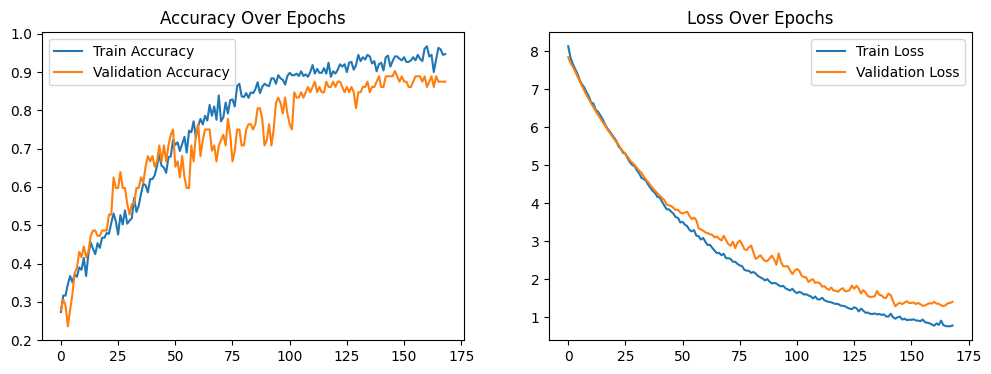

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.savefig('metrics.png')
plt.show()

In [19]:
test_loss, test_acc, test_recall = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Recall: {test_recall * 100:.2f}%")

40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 562ms/step - accuracy: 0.9208 - loss: 1.1065 - recall: 0.9188
Test Accuracy: 88.89%
Test Recall: 87.62%


40/40 ━━━━━━━━━━━━━━━━━━━━ 23s 503ms/step
Final Training Accuracy: 94.69%
Final Validation Accuracy: 87.50%
Test Accuracy: 88.89%

Classification Report :


,precision,recall,f1-score,support
adenocarcinoma,0.862595,0.941667,0.900398,240
large.cell.carcinoma,0.738462,0.941176,0.827586,102
normal,1.000000,0.962963,0.981132,108
squamous.cell.carcinoma,1.000000,0.744444,0.853503,180
accuracy,0.888889,0.888889,0.888889,0
macro avg,0.900264,0.897563,0.890655,630
weighted avg,0.905311,0.888889,0.889051,630


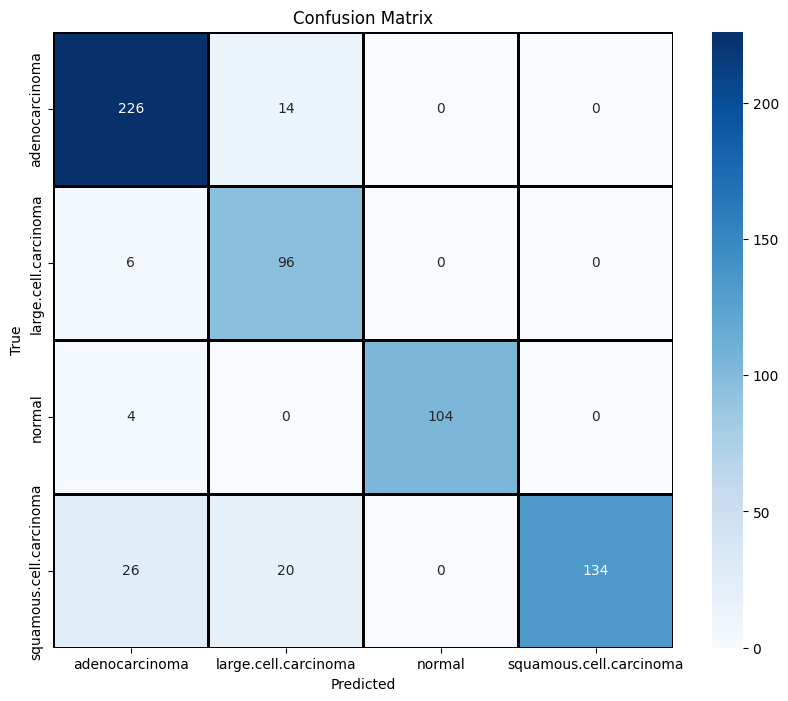

In [20]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

train_acc = history.history['accuracy'][-1]
print(f"Final Training Accuracy: {train_acc * 100:.2f}%")

val_acc = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {val_acc * 100:.2f}%")

test_loss, test_acc, test_recall = model.evaluate(test_generator, verbose=0)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

class_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report).transpose()
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
report_df['support'] = report_df['support'].astype(int)  
print("\nClassification Report :")
display(report_df)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names,
            linecolor='black', linewidths=1)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png') 
plt.show()